### Approach 1 in Transfer Learning - We initialize the network with a pretrained model, such as one trained on the ImageNet 1000 dataset, and then fine-tune the entire network

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

import itertools
import copy

In [ ]:
transformers = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # mean imagenet
                         [0.229, 0.224, 0.225]) # std imagenet
])

In [ ]:
dataset_colorectal_cancer = datasets.ImageFolder(root = ("/content/drive/MyDrive/MLProject/Data/Dataset/Dataset_1/Colorectal_Cancer"),
transform = transformers)

In [ ]:
print(dataset_colorectal_cancer)

Dataset ImageFolder
    Number of datapoints: 6000
    Root location: /content/drive/MyDrive/MLProject/Data/Dataset/Dataset_1/Colorectal_Cancer
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
train_ind, test_ind = train_test_split(list(range(len(dataset_colorectal_cancer.targets))),
                                       test_size=0.3, random_state = 0,stratify=dataset_colorectal_cancer.targets)

In [ ]:
train_set = torch.utils.data.Subset(dataset_colorectal_cancer, train_ind)
test_set = torch.utils.data.Subset(dataset_colorectal_cancer, test_ind)

In [ ]:
print(len(train_set))
print(len(test_set))

4200
1800


In [ ]:
batch_size = 64

In [ ]:
train_loader = DataLoader(train_set, shuffle=True, batch_size = batch_size, pin_memory = True) # create train loader
test_loader = DataLoader(test_set, batch_size = batch_size, pin_memory = True) # create test loader

In [ ]:
model_resnet18_pretrained = models.resnet18(weights='IMAGENET1K_V1')
num_features = model_resnet18_pretrained.fc.in_features
model_resnet18_pretrained.fc = torch.nn.Linear(num_features, 3)
print(model_resnet18_pretrained)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_epoch = 100
device = "cuda:0" # use 'cuda:0' to speed it up.
lr = 0.001

In [ ]:
model_resnet18_pretrained_training = copy.deepcopy(model_resnet18_pretrained)
model_resnet18_pretrained_training.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define opt function and learning rate
optimizer = torch.optim.SGD(model_resnet18_pretrained_training.parameters(), lr=lr)

# Define loss function and training criterion
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_data_metrics = []
test_data_metrics = []
train_true_labels = []
train_pred_labels = []
test_true_labels = []
test_pred_labels = []

In [ ]:
# Training
for epoch in range(num_epoch):
    model_resnet18_pretrained_training.train()
    train_loss = 0.0
    correct_train = 0.0
    total_train = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        out_preds = model_resnet18_pretrained_training(inputs)
        l = criterion(out_preds, labels)

        model_resnet18_pretrained_training.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.item()
        _, predicted_train = torch.max(out_preds.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        train_true_labels.extend(labels.cpu().numpy())
        train_pred_labels.extend(predicted_train.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_data_metrics.append([epoch+1, train_loss, train_accuracy])
    # Test
    model_resnet18_pretrained_training.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet18_pretrained_training(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_val == labels).sum().item()
            test_true_labels.extend(labels.cpu().numpy())
            test_pred_labels.extend(predicted_val.cpu().numpy())

    # Calculate validation metrics
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_data_metrics.append([epoch+1, test_loss, test_accuracy])
    # Print training and validation metrics for this epoch
    print(f"Epoch [{epoch+1}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1], Training Loss: 0.8353, Training Accuracy: 65.86%, Test Loss: 0.6513, Test Accuracy: 79.94%
Epoch [2], Training Loss: 0.5436, Training Accuracy: 85.05%, Test Loss: 0.4722, Test Accuracy: 87.50%
Epoch [3], Training Loss: 0.4008, Training Accuracy: 89.98%, Test Loss: 0.3706, Test Accuracy: 90.22%
Epoch [4], Training Loss: 0.3155, Training Accuracy: 92.45%, Test Loss: 0.3069, Test Accuracy: 92.06%
Epoch [5], Training Loss: 0.2622, Training Accuracy: 93.67%, Test Loss: 0.2626, Test Accuracy: 93.11%
Epoch [6], Training Loss: 0.2254, Training Accuracy: 94.45%, Test Loss: 0.2335, Test Accuracy: 93.56%
Epoch [7], Training Loss: 0.1959, Training Accuracy: 95.19%, Test Loss: 0.2119, Test Accuracy: 94.06%
Epoch [8], Training Loss: 0.1745, Training Accuracy: 95.93%, Test Loss: 0.1929, Test Accuracy: 94.67%
Epoch [9], Training Loss: 0.1552, Training Accuracy: 95.90%, Test Loss: 0.1776, Test Accuracy: 95.11%
Epoch [10], Training Loss: 0.1441, Training Accuracy: 96.48%, Test Loss: 0.1688, T

In [ ]:
train_data_pretrained_approach1_0001_64 = pd.DataFrame(train_data_metrics, columns = ["epoch", "train_loss", "train_accuracy"])
test_data_pretrained_approach1_0001_64 = pd.DataFrame(test_data_metrics, columns = ["epoch", "test_loss", "test_accuracy"])

In [ ]:
train_data_pretrained_approach1_0001_64.to_csv("/content/drive/MyDrive/MLProject/Data/Results/train_data_pretrained_approach1_0001_64.csv")
test_data_pretrained_approach1_0001_64.to_csv("/content/drive/MyDrive/MLProject/Data/Results/test_data_pretrained_approach1_0001_64.csv")

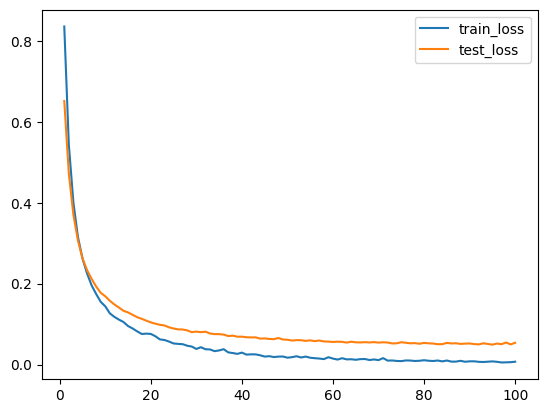

In [ ]:
plt.plot(train_data_pretrained_approach1_0001_64["epoch"], train_data_pretrained_approach1_0001_64["train_loss"], label = "train_loss")
plt.plot(test_data_pretrained_approach1_0001_64["epoch"], test_data_pretrained_approach1_0001_64["test_loss"], label = "test_loss")
plt.legend()

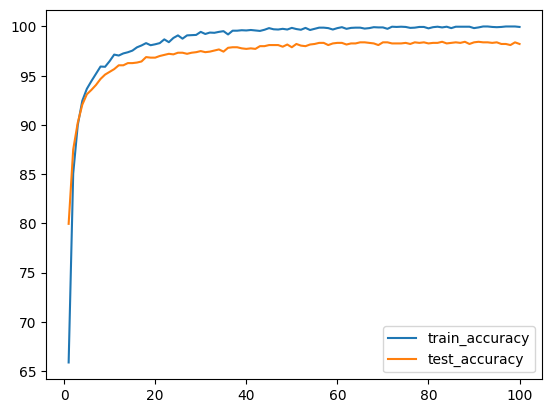

In [ ]:
plt.plot(train_data_pretrained_approach1_0001_64["epoch"], train_data_pretrained_approach1_0001_64["train_accuracy"], label = "train_accuracy")
plt.plot(test_data_pretrained_approach1_0001_64["epoch"], test_data_pretrained_approach1_0001_64["test_accuracy"], label = "test_accuracy")
plt.legend()

In [ ]:
torch.save(model_resnet18_pretrained_training.state_dict(),"/content/drive/MyDrive/MLProject/Data/Model/model_pretrained_approach1_0001_64_inference.pth")
torch.save(model_resnet18_pretrained_training,"/content/drive/MyDrive/MLProject/Data/Model/model_pretrained_approach1_0001_64_all.pt")

In [ ]:
classification_report_train_data_apprach1 =classification_report(train_true_labels, train_pred_labels, target_names=dataset_colorectal_cancer.classes)
print(classification_report_train_data_apprach1)

              precision    recall  f1-score   support

         MUS       1.00      1.00      1.00      1400
        NORM       1.00      1.00      1.00      1400
         STR       1.00      1.00      1.00      1400

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200



In [ ]:
with open("/content/drive/MyDrive/MLProject/Data/Results/classification_report_train_data_pretrained_apprach1_0001_64.txt", 'w') as file:
    file.write(classification_report_train_data_apprach1)

In [ ]:
classification_report_test_data_apprach1 =classification_report(test_true_labels, test_pred_labels, target_names=dataset_colorectal_cancer.classes)
print(classification_report_test_data_apprach1)

              precision    recall  f1-score   support

         MUS       0.98      0.97      0.98       600
        NORM       0.99      1.00      0.99       600
         STR       0.98      0.98      0.98       600

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [ ]:
with open("/content/drive/MyDrive/MLProject/Data/Results/classification_report_test_data_pretrained_apprach1_0001_64.txt", 'w') as file:
    file.write(classification_report_test_data_apprach1)

##Feature Extraction

In [ ]:
loaded_model = torch.load("/content/drive/MyDrive/MLProject/Data/Model/model_pretrained_approach1_0001_64_all.pt")
device = "cuda:0" # use 'cuda:0' to speed it up.

In [ ]:
resnet18_without_fc = torch.nn.Sequential(*list(loaded_model.children())[:-1])
resnet18_without_fc

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
batch_size = 64

data_loader = DataLoader(dataset_colorectal_cancer, shuffle=True, batch_size = batch_size, pin_memory = True) # create train loader
resnet18_without_fc.to(device)
resnet18_without_fc.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Initialize lists to store predicted labels and ground truth labels
extracted_features = []
class_labels = []

with torch.no_grad():
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        features = resnet18_without_fc(inputs)
        features = features.view(features.size(0), -1)

        class_labels.extend(labels.tolist())
        extracted_features.append(features)

extracted_features = torch.cat(extracted_features, dim=0)

In [ ]:
features_labels_pretrained_approach1_0001_64 = pd.DataFrame(extracted_features.cpu().numpy())
features_labels_pretrained_approach1_0001_64_full["labels"] = class_labels
features_labels_pretrained_approach1_0001_64_full.to_csv("/content/drive/MyDrive/MLProject/Data/Features/features_labels_pretrained_approach1_0001_64.csv")

In [ ]:
from sklearn.manifold import TSNE

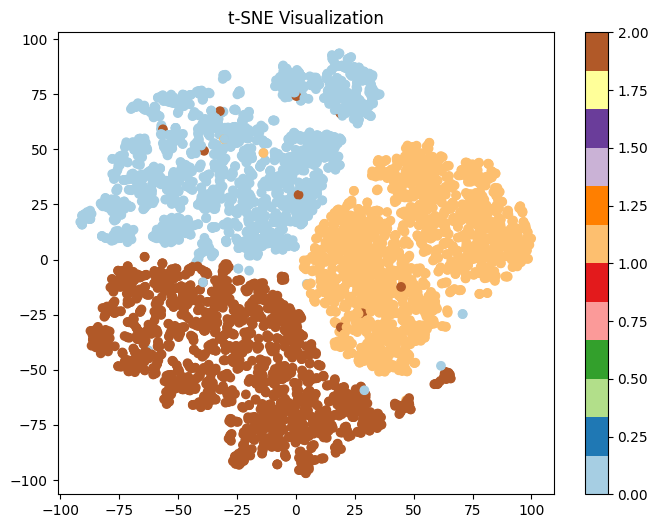

In [ ]:
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
X_tsne = tsne.fit_transform(extracted_features.cpu().numpy())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=class_labels, cmap=plt.cm.Paired)

# Define class labels and colors
class_colors = [scatter.to_rgba(i) for i in range(len(class_labels))]

# Create legend handles
#legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(class_labels, class_colors)]

# Add legend
#plt.legend(handles=legend_handles, title="Classes", loc='best')

plt.title("t-SNE Visualization")
plt.colorbar()
plt.show()

In [ ]:
class_colors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0),
 (0.6941176470588235, 0.349019607843

In [ ]:
class_labels

[2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
